✅ RMSE: 20.37
✅ MAE: 15.5974
✅ R² Score: 0.3249


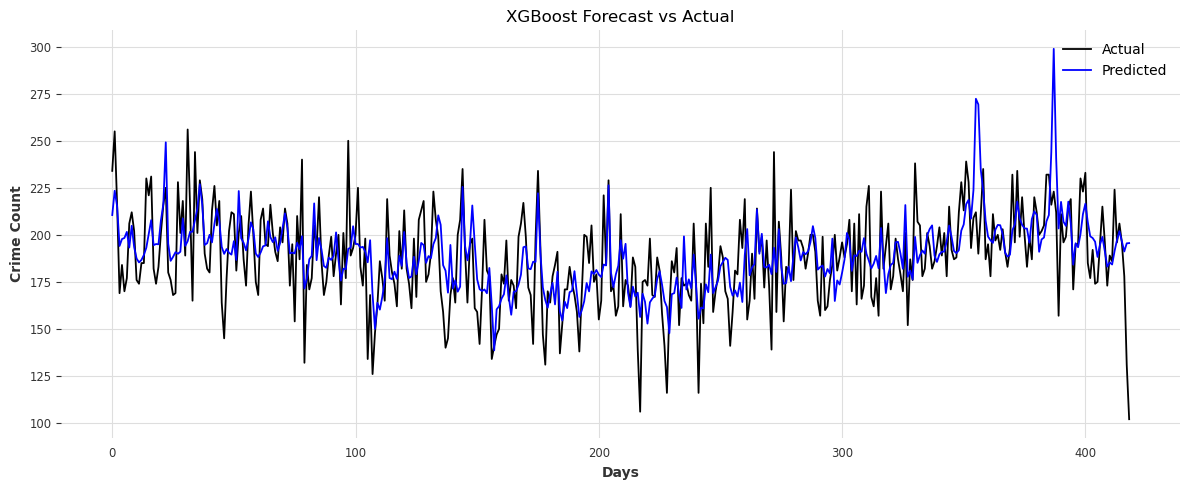

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# Step 1: Load and Prepare Data
# -------------------------
df = pd.read_csv('/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv', parse_dates=["FIRST_OCCURRENCE_DATE"])
df["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(df["FIRST_OCCURRENCE_DATE"])
df["Crime_Count"] = 1

# Daily aggregation
daily_crime = df.groupby(df["FIRST_OCCURRENCE_DATE"].dt.date).size().reset_index(name="Crime_Count")
daily_crime["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(daily_crime["FIRST_OCCURRENCE_DATE"])

# -------------------------
# Step 2: Feature Engineering
# -------------------------
daily_crime["day_of_week"] = daily_crime["FIRST_OCCURRENCE_DATE"].dt.dayofweek
daily_crime["month"] = daily_crime["FIRST_OCCURRENCE_DATE"].dt.month
daily_crime["year"] = daily_crime["FIRST_OCCURRENCE_DATE"].dt.year
daily_crime["day"] = daily_crime["FIRST_OCCURRENCE_DATE"].dt.day

# Lag features
daily_crime["lag1"] = daily_crime["Crime_Count"].shift(1)
daily_crime["lag7"] = daily_crime["Crime_Count"].shift(7)
daily_crime["rolling7"] = daily_crime["Crime_Count"].rolling(window=7).mean()
daily_crime.dropna(inplace=True)

# -------------------------
# Step 3: Train-Test Split
# -------------------------
X = daily_crime[["day_of_week", "month", "year", "day", "lag1", "lag7", "rolling7"]]
y = daily_crime["Crime_Count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------
# Step 4: Train XGBoost Model
# -------------------------
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# -------------------------
# Step 5: Predictions and Evaluation
# -------------------------
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {round(rmse, 4)}")
print(f"✅ MAE: {round(mae, 4)}")
print(f"✅ R² Score: {round(r2, 4)}")

# -------------------------
# Step 6: Visualization
# -------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual", color="black")
plt.plot(y_pred, label="Predicted", color="blue")
plt.title("XGBoost Forecast vs Actual")
plt.xlabel("Days")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - /Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 1674, number of used features: 6
[LightGBM] [Info] Start training from score 185.391278
✅ RMSE: 19.6612
✅ MAE: 15.3525
✅ R² Score: 0.3711


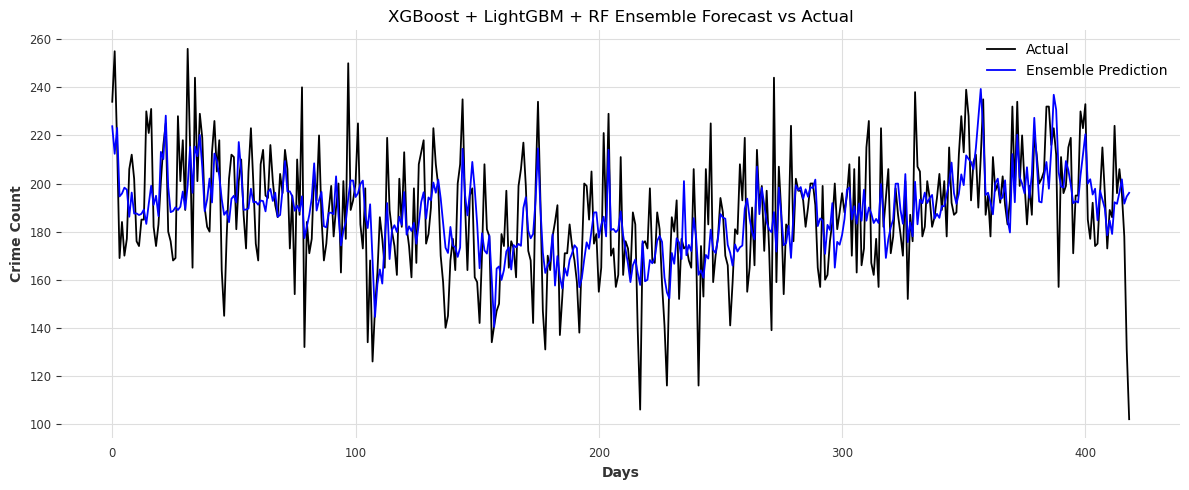

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv')

# Preprocessing
df["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(df["FIRST_OCCURRENCE_DATE"])
df["DATE"] = df["FIRST_OCCURRENCE_DATE"].dt.date
daily_crime = df.groupby("DATE").size().reset_index(name="Crime_Count")

# Time-based features
daily_crime["DATE"] = pd.to_datetime(daily_crime["DATE"])
daily_crime["dayofweek"] = daily_crime["DATE"].dt.dayofweek
daily_crime["month"] = daily_crime["DATE"].dt.month
daily_crime["day"] = daily_crime["DATE"].dt.day

# Lag and rolling features
daily_crime["lag1"] = daily_crime["Crime_Count"].shift(1)
daily_crime["lag7"] = daily_crime["Crime_Count"].shift(7)
daily_crime["rolling_mean_7"] = daily_crime["Crime_Count"].rolling(7).mean()

# Drop missing values
daily_crime.dropna(inplace=True)

# Features and target
X = daily_crime[["dayofweek", "month", "day", "lag1", "lag7", "rolling_mean_7"]]
y = daily_crime["Crime_Count"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base Models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
lgb = LGBMRegressor(n_estimators=100, random_state=42)

rf.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)
lgb.fit(X_train_scaled, y_train)

# Predictions from base models
pred_rf = rf.predict(X_test_scaled)
pred_xgb = xgb.predict(X_test_scaled)
pred_lgb = lgb.predict(X_test_scaled)

# Stack base model predictions
stacked_predictions = np.column_stack((pred_rf, pred_xgb, pred_lgb))

# Meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test)
final_preds = meta_model.predict(stacked_predictions)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, final_preds))  # Removed squared=False
mae = mean_absolute_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)



# Results
print(f"✅ RMSE: {round(rmse, 4)}")
print(f"✅ MAE: {round(mae, 4)}")
print(f"✅ R² Score: {round(r2, 4)}")

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_test)), y_test.values, label="Actual", color="black")
plt.plot(np.arange(len(final_preds)), final_preds, label="Ensemble Prediction", color="blue")
plt.xlabel("Days")
plt.ylabel("Crime Count")
plt.title("XGBoost + LightGBM + RF Ensemble Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - /Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - /var/folders/s0/9c8j0gnd1_l2cgnr9wq06b7r0000gn/T/ipykernel_99251/2558656600.py:102: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 1674, number of used features: 6
[LightGBM] [Info] Start training from score 185.391278

✅ RMSE: 19.6612
✅ MAE: 15.3525
✅ R² Score: 0.3711


WARNING - (py.warnings._showwarnmsg) - /Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



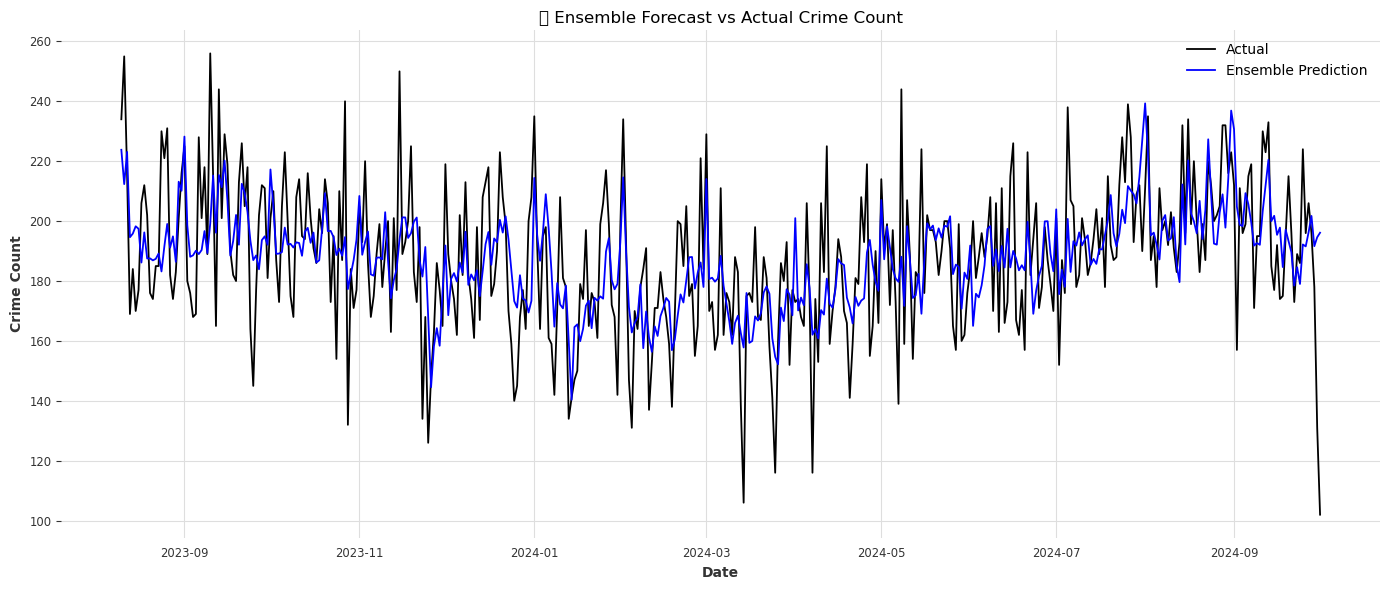

WARNING - (py.warnings._showwarnmsg) - /var/folders/s0/9c8j0gnd1_l2cgnr9wq06b7r0000gn/T/ipykernel_99251/2558656600.py:114: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



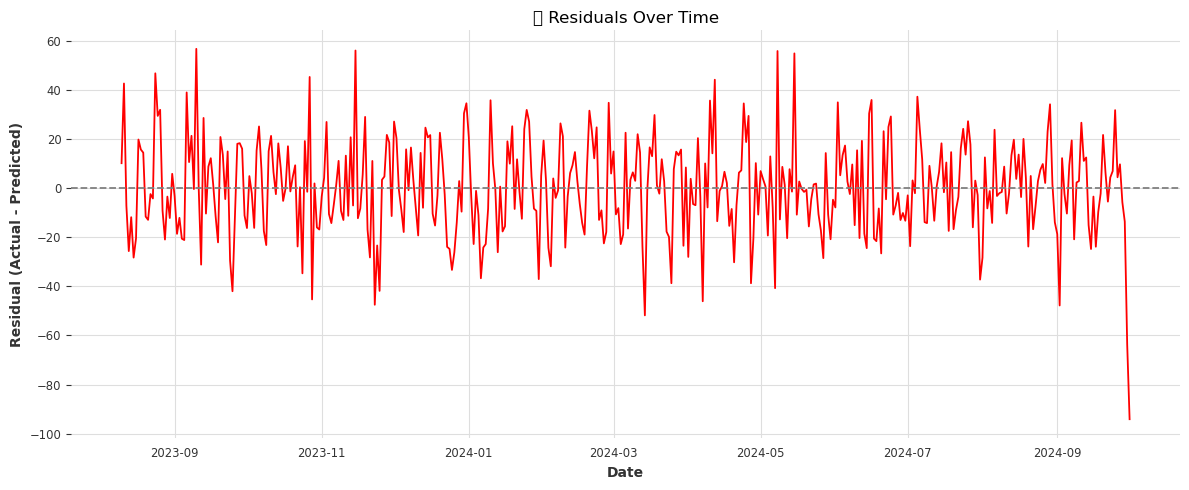

WARNING - (py.warnings._showwarnmsg) - /var/folders/s0/9c8j0gnd1_l2cgnr9wq06b7r0000gn/T/ipykernel_99251/2558656600.py:123: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



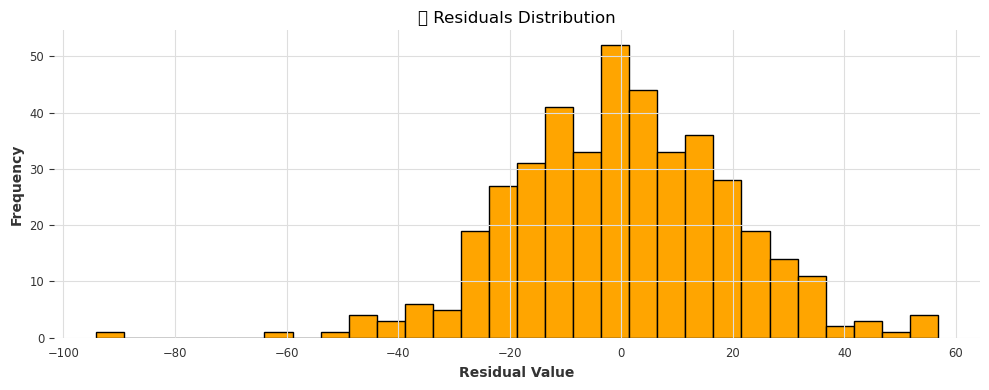

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ----------------------------------------
# Step 1: Load and Preprocess Data
# ----------------------------------------
df = pd.read_csv('/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv')

df["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(df["FIRST_OCCURRENCE_DATE"])
df["DATE"] = df["FIRST_OCCURRENCE_DATE"].dt.date
daily_crime = df.groupby("DATE").size().reset_index(name="Crime_Count")

# Time Features
daily_crime["DATE"] = pd.to_datetime(daily_crime["DATE"])
daily_crime["dayofweek"] = daily_crime["DATE"].dt.dayofweek
daily_crime["month"] = daily_crime["DATE"].dt.month
daily_crime["day"] = daily_crime["DATE"].dt.day

# Lag and Rolling Features
daily_crime["lag1"] = daily_crime["Crime_Count"].shift(1)
daily_crime["lag7"] = daily_crime["Crime_Count"].shift(7)
daily_crime["rolling_mean_7"] = daily_crime["Crime_Count"].rolling(7).mean()

# Drop NaNs and reset index for alignment
daily_crime.dropna(inplace=True)
daily_crime.reset_index(drop=True, inplace=True)


# ----------------------------------------
# Step 2: Split Data
# ----------------------------------------
X = daily_crime[["dayofweek", "month", "day", "lag1", "lag7", "rolling_mean_7"]]
y = daily_crime["Crime_Count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------
# Step 3: Train Base Models
# ----------------------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
lgb = LGBMRegressor(n_estimators=100, random_state=42)

rf.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)
lgb.fit(X_train_scaled, y_train)

# ----------------------------------------
# Step 4: Stacking and Meta-Model
# ----------------------------------------
pred_rf = rf.predict(X_test_scaled)
pred_xgb = xgb.predict(X_test_scaled)
pred_lgb = lgb.predict(X_test_scaled)

stacked_predictions = np.column_stack((pred_rf, pred_xgb, pred_lgb))

meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test)
final_preds = meta_model.predict(stacked_predictions)

# ----------------------------------------
# Step 5: Evaluation
# ----------------------------------------
rmse = np.sqrt(mean_squared_error(y_test, final_preds))
mae = mean_absolute_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

print(f"\n✅ RMSE: {round(rmse, 4)}")
print(f"✅ MAE: {round(mae, 4)}")
print(f"✅ R² Score: {round(r2, 4)}")

# ----------------------------------------
# Step 6: Visualization
# ----------------------------------------
result_df = pd.DataFrame()
result_df["Actual"] = y_test.values
result_df["Predicted"] = final_preds
result_df["DATE"] = daily_crime.iloc[y_test.index]["DATE"].values

# 📈 Forecast Plot
plt.figure(figsize=(14, 6))
plt.plot(result_df["DATE"], result_df["Actual"], label="Actual", color="black")
plt.plot(result_df["DATE"], result_df["Predicted"], label="Ensemble Prediction", color="blue")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.title("📊 Ensemble Forecast vs Actual Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Residuals Over Time
residuals = result_df["Actual"] - result_df["Predicted"]
plt.figure(figsize=(12, 5))
plt.plot(result_df["DATE"], residuals, label="Residuals", color="red")
plt.axhline(0, linestyle="--", color="gray")
plt.title("🔍 Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Residual Distribution
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=30, color="orange", edgecolor="black")
plt.title("📉 Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [52]:
mape = np.mean(np.abs((y_test - final_preds) / y_test)) * 100
print(f"📉 MAPE: {round(mape, 2)}%")


📉 MAPE: 8.53%


In [53]:
accuracy = 100 - mape
print(f"✅ Prediction Accuracy: {round(accuracy, 2)}%")


✅ Prediction Accuracy: 91.47%
